# Imports

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray

Saving kaggle.json to kaggle.json
100% 1.51G/1.51G [01:25<00:00, 17.7MB/s]
100% 1.51G/1.51G [01:25<00:00, 19.1MB/s]


In [ ]:
# !unzip chest-xray-pneumonia.zip
!unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

In [ ]:
import os
imagefiles=[]
labels=[]
for folder in os.listdir('./data/chest_xray/chest_xray/train'):
  path=os.path.join('./data/chest_xray/chest_xray/train',folder)
  for images in os.listdir(path):
    imagefiles.append(os.path.join(path,images))
    labels.append(folder)
testimages=[]
testlabel=[]
for folder in os.listdir('./data/chest_xray/chest_xray/test'):
  path=os.path.join('./data/chest_xray/chest_xray/test',folder)
  for images in os.listdir(path):
    testimages.append(os.path.join(path,images))
    testlabel.append(folder)
enc={}
for i,label in enumerate(os.listdir('./data/chest_xray/chest_xray/train')):
  enc[label]=i

# VAE: Load Data, prepare methods

In [ ]:
class Data(Dataset):
  def __init__(self,imagefiles,labels,testimages,testlabel,mode,enc=None,transform=None):
    self.imagefiles=imagefiles
    self.labels=labels
    self.testimages=testimages
    self.testlabel=testlabel
    self.mode=mode
    self.transform=transform
    self.enc=enc
  def __getitem__(self,idx):
    if self.mode=='train':
      image=Image.open(self.imagefiles[idx])
      image=np.asarray(image)
      image=torch.from_numpy(image)
      label=self.labels[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
    if self.mode=='test':
      image=Image.open(self.testimages[idx])
      image=np.asarray(image)
      image=torch.from_numpy(image)
      label=self.testlabel[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
  def __len__(self):
    if self.mode=='train':
      return len(self.imagefiles)
    if self.mode=='test':
      return len(self.testimages)

In [ ]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((100,100)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
                              ])

In [ ]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)


In [ ]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

# VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #3*128*128=49152
        self.fc1 = nn.Linear(10000, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 10000)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 10000))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Parameters & Run Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
best_test_loss = float('inf')
best_loss_checker=0
for epochs in range(0,31):
  train_loss=0
  test_loss = 0
  for img,lab in trainloader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    optimizer.zero_grad()
    img_sample, mu1, var = model(img)
    cx_loss= F.binary_cross_entropy(img_sample, img, size_average=False)

    #KL Loss (Best according to literature)
    kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
    loss = cx_loss+ kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      for img,lab in testloader:
        img = img.view(-1, 10000)
        img=F.softmax(img)
        img_sample, mu1, var = model(img)
        cx_loss= F.binary_cross_entropy(img_sample, img, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
        loss = cx_loss+ kl_loss
        test_loss += loss.item()

  train_loss /= len(trainloader)
  test_loss /= len(testloader)
  print(f'Epoch: {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

  if best_test_loss > test_loss:
    best_test_loss = test_loss
    best_loss_checker = 1
  else:
    best_loss_checker += 1
  if best_loss_checker > 3:
    break

Started accessing trainloader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Loss: 211.74, Test Loss: 54.50
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 53.84, Test Loss: 53.43
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 53.10, Test Loss: 52.77
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 52.42, Test Loss: 51.98
Started accessing trainloader
accessing test loader
Epoch 4, Train Loss: 51.62, Test Loss: 51.25
Started accessing trainloader
accessing test loader
Epoch 5, Train Loss: 51.12, Test Loss: 50.96
Started accessing trainloader
accessing test loader
Epoch 6, Train Loss: 50.92, Test Loss: 50.86
Started accessing trainloader
accessing test loader
Epoch 7, Train Loss: 50.87, Test Loss: 50.85
Started accessing trainloader
accessing test loader
Epoch 8, Train Loss: 50.90, Test Loss: 50.97
Started accessing trainloader
accessing test loader
Epoch 9, Train Loss: 50.95, Test Loss: 51.00
Started accessing trainloader
accessing test loader
Epoch 10, Train Loss: 51.01, 

# Save to drive

In [ ]:
#Loading Only NORMAL images
imagefiles=[]
labels=[]

for folder in os.listdir('./data/chest_xray/chest_xray/train'):
  print("NOT saving this: ", folder)
  if folder == "NORMAL":
    print("Saving this: ", folder)
    path=os.path.join('./data/chest_xray/chest_xray/train',folder)
    for images in os.listdir(path):
      imagefiles.append(os.path.join(path,images))
      labels.append(folder)


testimages=[]
testlabel=[]
for folder in os.listdir('./data/chest_xray/chest_xray/test'):
  print("NOT saving this: ", folder)
  if folder == "NORMAL":
    print("Saving this: ", folder)
    path=os.path.join('./data/chest_xray/chest_xray/test',folder)
    for images in os.listdir(path):
      testimages.append(os.path.join(path,images))
      testlabel.append(folder)


enc={}
for i,label in enumerate(os.listdir('./data/chest_xray/chest_xray/train')):
  print("NOT saving this: ", label)
  if label == "NORMAL":
      print("Saving this: ", label)
      enc[label]=i

NOT saving this:  PNEUMONIA
NOT saving this:  CORONA
Saving this:  CORONA
NOT saving this:  NORMAL
Saving this:  NORMAL
NOT saving this:  PNEUMONIA
NOT saving this:  CORONA
Saving this:  CORONA
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
Appending to test
NOT saving this:  NORMAL
Saving this:  NORMAL
NOT saving this:  PNEUMONIA
NOT saving this:  CORONA
NOT saving this:  NORMAL
Saving this:  NORMAL


In [ ]:
trainset=Data(imagefiles,labels,testimages,testlabel,'train',enc,transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)


In [ ]:
testset=Data(imagefiles,labels,testimages,testlabel,'test',enc,transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

In [ ]:
best_test_loss = float('inf')
best_loss_checker=0
for epochs in range(0,31):
  train_loss=0
  test_loss = 0
  for img,lab in trainloader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    optimizer.zero_grad()
    img_sample, mu1, var = model(img)
    cx_loss= F.binary_cross_entropy(img_sample, img, size_average=False)
    kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
    loss = cx_loss+ kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('accessing test loader')
      for img,lab in testloader:
        img = img.view(-1, 10000)
        img=F.softmax(img)
        img_sample, mu1, var = model(img)
        cx_loss= F.binary_cross_entropy(img_sample, img, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
        loss = cx_loss+ kl_loss
        test_loss += loss.item()

  train_loss /= len(trainloader)
  test_loss /= len(testloader)
  print(f'Epoch {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    best_loss_checker = 1
  else:
    best_loss_checker += 1
  if best_loss_checker > 3:
    break

Started accessing trainloader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Loss: 50.82, Test Loss: 50.73
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 50.73, Test Loss: 50.67
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 50.76, Test Loss: 50.77
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 50.90, Test Loss: 50.66
Started accessing trainloader
accessing test loader
Epoch 4, Train Loss: 50.72, Test Loss: 50.66
Started accessing trainloader
accessing test loader
Epoch 5, Train Loss: 50.73, Test Loss: 50.77
Started accessing trainloader
accessing test loader
Epoch 6, Train Loss: 50.80, Test Loss: 50.69
Started accessing trainloader
accessing test loader
Epoch 7, Train Loss: 50.73, Test Loss: 50.65
Started accessing trainloader
accessing test loader
Epoch 8, Train Loss: 50.81, Test Loss: 50.81
Started accessing trainloader
accessing test loader
Epoch 9, Train Loss: 50.76, Test Loss: 50.64
Started accessing trainloader
accessing test loader
Epoch 10, Train Loss: 50.71, T

In [ ]:
image_dir = '/content/gdrive/My Drive/generated_NORMAL'

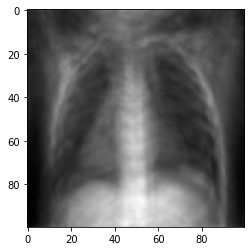

In [ ]:
#Generating 500 new images
for img_num in range(1,501):
    z = torch.randn(1, 20)
    reconstructed_img = model.decode(z)
    img = reconstructed_img.view(100, 100).data
    plt.imshow(img,cmap='gray')
    name_img = img_num + 110
    plt.savefig("{}/VAE_{}.jpg".format(image_dir, name_img))

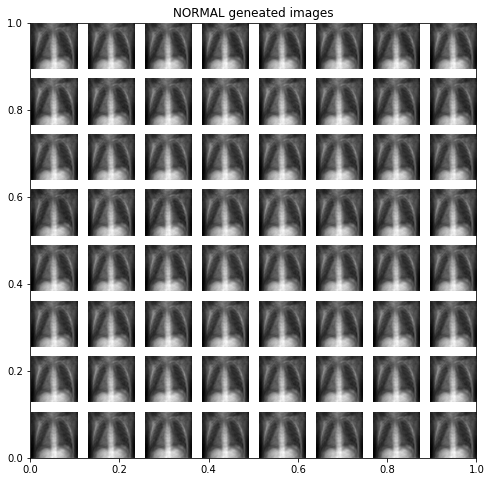

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
plt.title("NORMAL geneated images")
columns = 8
rows = 8
for i in range(1, columns*rows +1):
    z = torch.randn(1, 20)
    reconstructed_img = model.decode(z)
    img = reconstructed_img.view(100, 100).data
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.show()